## Dog Breed Classification

In this project we will use traditional CNN, CNN with data augmentation and finally transfer Learning by VGG16 model with weights pre-trained on Imagenet to solve the dog breed classification problem

In [0]:
%tensorflow_version 2.x
import numpy as np
import pandas as pd
import tensorflow as tf
from tqdm import tqdm
from zipfile import ZipFile
from os.path import join, exists, expanduser
from google.colab import drive
from matplotlib import pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import cv2
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import optimizers

### Load Dataset Files

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


Now, upload the given dataset file shared with you in your google drive and give its path for the below given `project_path` variable. For example, a path is given below according to the file path in our google drive. You need to change this to match the path of yours.

In [0]:
project_path = "/content/drive/My Drive/R7_ProjectCNN/"

Run the below code to extract all the images in the train.zip files given in the dataset. We are going to use these images as train and validation sets and their labels in further steps.

In [0]:
from zipfile import ZipFile
with ZipFile(project_path+'train.zip', 'r') as z:
  z.extractall()

Repeat the same step for test.zip

In [0]:
from zipfile import ZipFile
with ZipFile(project_path+'test.zip', 'r') as z:
  z.extractall()

Repeat the same step for sample_submission.csv.zip

In [0]:
from zipfile import ZipFile
with ZipFile(project_path+'sample_submission.csv.zip', 'r') as z:
  z.extractall()

Repeat the same step for labels.csv.zip

In [0]:
from zipfile import ZipFile

with ZipFile(project_path+'labels.csv.zip', 'r') as z:
  z.extractall()

After this process, we will have 4 files - Train folder, test folder and labels.csv and sample_submission.csv as part of your google drive

### Read labels.csv file using pandas

In [0]:
import pandas as pd
labels_df = pd.read_csv("/content/labels.csv")
labels_df.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [0]:
labels_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10222 entries, 0 to 10221
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      10222 non-null  object
 1   breed   10222 non-null  object
dtypes: object(2)
memory usage: 159.8+ KB


In [0]:
#check for missing values
labels_df.isnull().sum()

id       0
breed    0
dtype: int64

### Print the count of each category of Dogs given in the dataset



In [0]:
labels_df['breed'].value_counts()

scottish_deerhound      126
maltese_dog             117
afghan_hound            116
entlebucher             115
bernese_mountain_dog    114
                       ... 
brabancon_griffon        67
komondor                 67
golden_retriever         67
briard                   66
eskimo_dog               66
Name: breed, Length: 120, dtype: int64

In [0]:
labels_df['breed'].nunique()

120

### Get one-hot encodings of labels

In [0]:
#doing one hot encoding using get_dummies from pandas
#using get_dummies and OHE would give the same result, except that we cannot use get_dummies() when we go for productionizing our model. 

targets = pd.Series(labels_df['breed'])
one_hot = pd.get_dummies(targets, sparse=True)
one_hot_labels = np.asarray(one_hot)


In [0]:
one_hot_labels[0]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=uint8)

In [0]:
labels_df.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


## Preparing training dataset
1. Write a code which reads each and every id from labels.csv file and loads the corresponding image (in RGB - 128, 128, 3) from the train folder. <br>
2. Create 2 variables <br> 
     a.  x_train - Should have all the images of the dogs from train folder <br>
     b.  y_train - Corresponding label of the dog <br>
<u>Note:</u> The id of the dog images and its corresponding labels are available in labels.csv file   
<u>Hint:</u> Watch the video shared on "Preparing the training dataset" if you face issue on creating the training dataset

In [0]:
labels_df['id'].nunique()

10222

In [0]:
rows = 128
cols = 128
channels = 3

In [0]:
from tqdm import tqdm
import cv2
X_train = []
y_train = []

for f, img in tqdm(labels_df.values): 
	train_img = cv2.imread('/content/train/{}.jpg'.format(f),1)
	train_img_resize = cv2.resize(train_img, (rows, cols))
	X_train.append(train_img_resize)
	y_train.append(img)
	

100%|██████████| 10222/10222 [00:31<00:00, 322.43it/s]


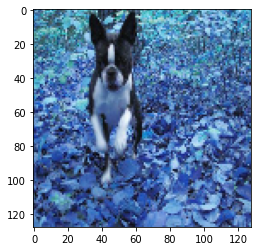

In [0]:
import matplotlib.pyplot as plt
plt.imshow(X_train[0])

In [0]:
y_train[0]

'boston_bull'

Normalize the training data and convert into 4 dimensions so that it can be used as an input to conv layers in the model

In [0]:
X_train[0].shape

(128, 128, 3)

In [0]:
one_hot.shape

(10222, 120)

In [0]:
encoded_labels = one_hot
#assign the one hot encoded values to y_train
y_train = one_hot

In [0]:
#convert x_train and y_train to a nparray before going for train_test_split
import numpy as np
y_train = np.array(y_train)

In [0]:
X_train = np.array(X_train)

In [0]:
X_train[0].shape

(128, 128, 3)

In [0]:
#do the test train split with test = 20%
from sklearn.model_selection import train_test_split
x2_train, x2_val, y2_train, y2_val = train_test_split(X_train, y_train, test_size=0.2, random_state=2)
print (len(x2_train))
print (len(x2_val))

8177
2045


In [0]:
x2_train[0].shape

(128, 128, 3)

In [0]:
#now reshape train data before normalizing it
x2_train = x2_train.reshape(x2_train.shape[0], rows, cols, channels)

In [0]:
#now reshape val data before normalizing it
x2_val = x2_val.reshape(x2_val.shape[0],128,128,3)

In [0]:
# normalize train data
x2_train = x2_train/255.

# normalize val data
x2_val = x2_val/255.

In [0]:
print (x2_train.shape)
print (x2_val.shape)

(8177, 128, 128, 3)
(2045, 128, 128, 3)


In [0]:
print(y2_train.shape)
print(y2_val.shape)

(8177, 120)
(2045, 120)


### Loading the test data
Read the id column from the samples_submission.csv and store it in test_img

In [0]:
df = pd.read_csv("/content/sample_submission.csv")
df.head()

,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,beagle,bedlington_terrier,bernese_mountain_dog,black-and-tan_coonhound,blenheim_spaniel,bloodhound,bluetick,border_collie,border_terrier,borzoi,boston_bull,bouvier_des_flandres,boxer,brabancon_griffon,briard,brittany_spaniel,bull_mastiff,cairn,cardigan,chesapeake_bay_retriever,chihuahua,chow,clumber,cocker_spaniel,collie,curly-coated_retriever,dandie_dinmont,dhole,dingo,doberman,...,norwegian_elkhound,norwich_terrier,old_english_sheepdog,otterhound,papillon,pekinese,pembroke,pomeranian,pug,redbone,rhodesian_ridgeback,rottweiler,saint_bernard,saluki,samoyed,schipperke,scotch_terrier,scottish_deerhound,sealyham_terrier,shetland_sheepdog,shih-tzu,siberian_husky,silky_terrier,soft-coated_wheaten_terrier,staffordshire_bullterrier,standard_poodle,standard_schnauzer,sussex_spaniel,tibetan_mastiff,tibetan_terrier,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
0,000621fb3cbb32d8935728e48679680e,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333
1,00102ee9d8eb90812350685311fe5890,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333
2,0012a730dfa437f5f3613fb75efcd4ce,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333
3,001510bc8570bbeee98c8d80c8a95ec1,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333

In [0]:
df.shape

(10357, 121)

In [0]:
test_img = df['id']

Run the below code to load the test image files in x_test_feature

In [0]:
# in the original code the 2nd parameter in imread command below is given as 0, which means we read it as a grey scale image.
# I changed that parameter to 1 which would mean that we will load it as RGB image
x_test_feature = []
i = 0 # initialisation
for f in tqdm(test_img.values): # f for format ,jpg
    img = cv2.imread('/content/test/{}.jpg'.format(f), 1)
    img_resize = cv2.resize(img, (rows, cols)) 
    x_test_feature.append(img_resize)

100%|██████████| 10357/10357 [00:31<00:00, 333.95it/s]


Normalize the test data and convert it into 4 dimensions

In [0]:
len(x_test_feature)

10357

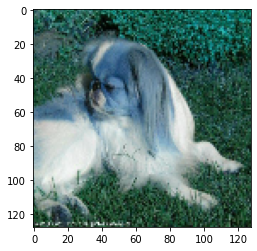

In [0]:
import matplotlib.pyplot as plt
plt.imshow(x_test_feature[0])

In [0]:
#convert this into a nparray
x_test_feature = np.array(x_test_feature)
print("shape = ",x_test_feature[0].shape)
#now reshape test data before normalizing it
x_test_feature = x_test_feature.reshape(x_test_feature.shape[0], rows, cols, channels)
# normalize test data
x_test_feature = x_test_feature/255.
print(x_test_feature.shape)

shape =  (128, 128, 3)
(10357, 128, 128, 3)


### Build a basic conv neural network with 2 conv layers (kernel sizes - 5 and 3) add layers as mentioned below for classification.

1. Add a Dense layer with 256 neurons with `relu` activation

2. Add a Dense layer with 120 neurons as final layer (as there are 120 classes in the given dataset) with `softmax` activation for classifiaction. 

In [0]:
tf.keras.backend.clear_session()
#Initialize the model
model = tf.keras.models.Sequential()

model.add(tf.keras.layers.Conv2D(64,kernel_size=(5,5), input_shape=(rows, cols, channels), activation='relu'))

#Normalize the data
model.add(tf.keras.layers.BatchNormalization())

#Add second convolutional layer
model.add(tf.keras.layers.Conv2D(32, kernel_size=(3,3), activation='relu'))

#Flatten connected layers
model.add(tf.keras.layers.Flatten())
#First Dense layer
model.add(tf.keras.layers.Dense(256, activation='relu'))
#second dense layer
model.add(tf.keras.layers.Dense(120, activation='softmax'))

### Use batch_size = 128 and epochs = 10 and execute the model

In [0]:
BATCH_SIZE = 128
EPOCHS = 10

In [0]:
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [0]:
    # Train the model
    model.fit(x2_train, y2_train, batch_size=BATCH_SIZE, epochs=EPOCHS, 
              validation_data=(x2_val, y2_val))

Epoch 1/10
64/64 [==============================] - 30s 472ms/step - loss: 14.0631 - accuracy: 0.0102 - val_loss: 4.7880 - val_accuracy: 0.0088
Epoch 2/10
64/64 [==============================] - 27s 423ms/step - loss: 4.7533 - accuracy: 0.0249 - val_loss: 4.7834 - val_accuracy: 0.0122
Epoch 3/10
64/64 [==============================] - 27s 422ms/step - loss: 4.5346 - accuracy: 0.0482 - val_loss: 4.7317 - val_accuracy: 0.0186
Epoch 4/10
64/64 [==============================] - 27s 423ms/step - loss: 3.8050 - accuracy: 0.1690 - val_loss: 4.6955 - val_accuracy: 0.0210
Epoch 5/10
64/64 [==============================] - 27s 424ms/step - loss: 2.2702 - accuracy: 0.4847 - val_loss: 4.8680 - val_accuracy: 0.0293
Epoch 6/10
64/64 [==============================] - 27s 425ms/step - loss: 0.6338 - accuracy: 0.8698 - val_loss: 5.8099 - val_accuracy: 0.0254
Epoch 7/10
64/64 [==============================] - 27s 425ms/step - loss: 0.0876 - accuracy: 0.9902 - val_loss: 7.4939 - val_accuracy: 0.023

In [0]:
  loss, accuracy = model.evaluate(x2_val, y2_val)
  print("val loss = ",loss)
  print("val accuracy", accuracy)

64/64 [==============================] - 2s 37ms/step - loss: 9.2205 - accuracy: 0.0293
val loss =  9.2205171585083
val accuracy 0.029339853674173355


#The model accuracy is very poor !!!!

### Use Data Augmentation in the above model to see if the accuracy improves


In [0]:
from keras.preprocessing.image import ImageDataGenerator

# This will do preprocessing and realtime data augmentation:
datagen = ImageDataGenerator(
    featurewise_center=False,  # set input mean to 0 over the dataset
    samplewise_center=False,  # set each sample mean to 0
    featurewise_std_normalization=False,  # divide inputs by std of the dataset
    samplewise_std_normalization=False,  # divide each input by its std
    zca_whitening=False,  # apply ZCA whitening
    rotation_range=50,  # randomly rotate images in the range (degrees, 0 to 180)
    width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=True,  # randomly flip images
    vertical_flip=True)  # randomly flip images

# Prepare the generator
#datagen.fit(x_train)

Using TensorFlow backend.


### Using the above objects, create the image generators with variable names `train_generator` and `val_generator`

You need to use train_datagen.flow() and val_datagen.flow()

In [0]:
train_generator = datagen.flow(x2_train, y2_train, batch_size=BATCH_SIZE)
val_generator = datagen.flow(x2_val, y2_val, batch_size=BATCH_SIZE)

### Fit the model using fit_generator() using `train_generator` and `val_generator` from the above step with 10 epochs

In [0]:
model.fit_generator(train_generator,
                    steps_per_epoch=64,
                    epochs=10,
                    validation_data=val_generator, validation_steps=64)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/10
64/64 [==============================] - 65s 1s/step - loss: 5.0395 - accuracy: 0.0126 - val_loss: 6.1876 - val_accuracy: 0.0079
Epoch 2/10
64/64 [==============================] - 65s 1s/step - loss: 4.7682 - accuracy: 0.0149 - val_loss: 5.0509 - val_accuracy: 0.0103
Epoch 3/10
64/64 [==============================] - 64s 1s/step - loss: 4.7477 - accuracy: 0.0220 - val_loss: 4.8336 - val_accuracy: 0.0131
Epoch 4/10
64/64 [==============================] - 64s 1s/step - loss: 4.7038 - accuracy: 0.0221 - val_loss: 4.7072 - val_accuracy: 0.0163
Epoch 5/10
64/64 [==============================] - 64s 1s/step - loss: 4.6702 - accuracy: 0.0225 - val_loss: 4.6755 - val_accuracy: 0.0229
Epoch 6/10
64/64 [==============================] - 64s 1s/step - loss: 4.6443 - accuracy: 0.0237 - val_loss: 4.6671 - val_accuracy: 0.0218
Epoch 7/10
64/64 [==============================] - 64s 1s/step - loss: 4.6344 - acc

# Model accuracy is still poor!!!

### Lets use Transfer Learning

Download the vgg wieght file from here : https://github.com/MinerKasch/applied_deep_learning/blob/master/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5


Use the below code to load VGG16 weights trained on ImageNet

In [0]:
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
base_model = VGG16(weights=("/content/drive/My Drive/R7_ProjectCNN//vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5"),
                   include_top=False, pooling='avg')

Print the summary of the base_model

In [0]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

In [0]:
#Freezing the base_model(VGG16) layers to be non-trainable. Opening the last CNN layer as trainable (to improve the accuracy)
base_model.get_layer('block1_conv1').trainable = False
base_model.get_layer('block1_conv2').trainable = False
base_model.get_layer('block2_conv1').trainable = False
base_model.get_layer('block2_conv2').trainable = False
base_model.get_layer('block3_conv1').trainable = False
base_model.get_layer('block3_conv2').trainable = False
base_model.get_layer('block3_conv3').trainable = False
base_model.get_layer('block4_conv1').trainable = False
base_model.get_layer('block4_conv2').trainable = False
base_model.get_layer('block4_conv3').trainable = False
base_model.get_layer('block5_conv1').trainable = False
base_model.get_layer('block5_conv2').trainable = False
base_model.get_layer('block5_conv3').trainable = True

### Add the following classification layers to the imported VGG Model <br>
1. Flatten Layer
2. Dense layer with 1024 neurons with activation as Relu
3. Dense layer with 256 neurons with activation as Relu
4. Dense layer with 120 neurons with activation as Softmax

In [0]:
# Clear the session before building the model
tf.keras.backend.clear_session()

#Create a new model
model_new = tf.keras.models.Sequential()

#Add the base VGG model
model_new.add(base_model)

#Flatten the output
model_new.add(tf.keras.layers.Flatten())

#First Dense layer
model_new.add(tf.keras.layers.Dense(1024, activation='relu',name='dense_1'))
#model_new.add(tf.keras.layers.Dropout(0.25))

#Second Dense layer
model_new.add(tf.keras.layers.Dense(256, activation='relu',name='dense_2'))
#model_new.add(tf.keras.layers.Dropout(0.25))

#Third Dense layer
model_new.add(tf.keras.layers.Dense(120, activation='softmax',name='prediction'))

In [0]:
model_new.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 512)               14714688  
_________________________________________________________________
flatten (Flatten)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              525312    
_________________________________________________________________
dense_2 (Dense)              (None, 256)               262400    
_________________________________________________________________
prediction (Dense)           (None, 120)               30840     
Total params: 15,533,240
Trainable params: 3,178,360
Non-trainable params: 12,354,880
_________________________________________________________________


### Make all the layers in the base_model (VGG16) to be non-trainable

In [0]:
#Freezing the base_model(VGG16) layers to be non-trainable. Opening the last CNN layer as trainable (to improve the accuracy)
for layer in model_new.layers:
    if("dense_1" in layer.name):
        print(layer.name)
        layer.trainable = True
    if("dense_2" in layer.name):
        print(layer.name)
        layer.trainable = True
    if("prediction" in layer.name):
        print(layer.name)
        layer.trainable = True

dense_1
dense_2
prediction


### Fit and compile the model with batch_size = 128 and epochs = 10 and execute the model

Try to get training and validation accuracy to be more than 90%

In [0]:
BATCH_SIZE = 128
EPOCHS = 30


In [0]:
rmsprop = optimizers.RMSprop(lr=0.001, rho=0.9, momentum=0.0)
model_new.compile(optimizer='rmsprop',loss='categorical_crossentropy',metrics=['accuracy'])
#model_new.compile(optimizer=rmsprop,loss='categorical_crossentropy',metrics=['accuracy'])

In [0]:
#Saving the best model using model checkpoint callback
model_checkpoint=tf.keras.callbacks.ModelCheckpoint('cv_project_model.h5', 
                                                    save_best_only=True, 
                                                    monitor='accuracy', 
                                                    mode='max', 
                                                    verbose=1)

In [0]:
# Train the model
model_new.fit(x2_train, y2_train, batch_size=BATCH_SIZE, epochs=EPOCHS, 
              validation_data=(x2_val, y2_val))
#model_new.fit_generator(train_generator, steps_per_epoch=64, epochs=EPOCHS, 
#              validation_data=val_generator, validation_steps=64)


Epoch 1/30
64/64 [==============================] - 38s 601ms/step - loss: 4.6810 - accuracy: 0.0297 - val_loss: 4.5385 - val_accuracy: 0.0474
Epoch 2/30
64/64 [==============================] - 30s 473ms/step - loss: 3.9331 - accuracy: 0.1035 - val_loss: 3.7190 - val_accuracy: 0.1139
Epoch 3/30
64/64 [==============================] - 30s 474ms/step - loss: 3.3822 - accuracy: 0.1783 - val_loss: 3.6685 - val_accuracy: 0.1599
Epoch 4/30
64/64 [==============================] - 30s 473ms/step - loss: 2.9806 - accuracy: 0.2495 - val_loss: 3.3969 - val_accuracy: 0.1878
Epoch 5/30
64/64 [==============================] - 30s 473ms/step - loss: 2.6579 - accuracy: 0.3128 - val_loss: 3.2312 - val_accuracy: 0.2108
Epoch 6/30
64/64 [==============================] - 30s 474ms/step - loss: 2.3461 - accuracy: 0.3767 - val_loss: 3.0805 - val_accuracy: 0.2440
Epoch 7/30
64/64 [==============================] - 30s 474ms/step - loss: 2.0544 - accuracy: 0.4436 - val_loss: 3.0176 - val_accuracy: 0.2606

In [0]:
  loss, accuracy = model_new.evaluate(x2_val, y2_val)
  print("val loss = ",loss)
  print("val accuracy", accuracy)

64/64 [==============================] - 8s 122ms/step - loss: 6.1459 - accuracy: 0.2773
val loss =  6.145907402038574
val accuracy 0.2772616147994995


# Observations: 
1.With transfer learning weights from VGG16, there is a huge improvement in the model validation accuracy. 
2. After making weights, in the last VGG16 layer, trainable the model validation accuracy has improved from around 22% to ~29%.
3. The training accuracy seems to be very much higher than the validation accuracy which is clear cut case of the model over-fitting. 
4. Data augmentation seems to improve the validation accuracy a little bit, but still the accuracy is very poor. 
5. If we want to achieve higher validation/test accuracies, the best way is to try out transfer learning from VGG19, ResNet and other proven models. 